# 🧪 Custom Bagging Classification

In this notebook, we implement bagging **from scratch**. We then compare the performance of these implementations with **scikit-learn**'s `BaggingClassifier` and `DecisionTreeClassifier` models.

### ⚙️ Importing Libraries & Environment Setup

In [1]:
from copy import deepcopy
from math import ceil
from typing import Any

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from numpy.random import Generator as RandomGenerator
from numpy.typing import NDArray
from sklearn.datasets import make_circles
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
)
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [2]:
%matplotlib inline

pd.set_option("display.width", 150)
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", None)

### 🧰 Utility Functions

In [3]:
def evaluate_classification_models(
    predictions: dict[str, NDArray[np.float64]], y: NDArray[np.float64]
) -> pd.DataFrame:
    """Evaluate multiple classification model predictions on the provided dataset.

    Args:
        predictions (dict[str, NDArray[np.float64]]): Dictionary mapping model names
            to predicted target arrays (binary or probabilities) for the dataset.
        y (NDArray[np.float64]): True binary target values of shape (n_samples,).

    Returns:
        pd.DataFrame: DataFrame containing classification metrics — Accuracy, Precision,
            Recall, F1-score, and ROC AUC — for each model. Columns correspond to
            model names, rows correspond to the metric names.
    """
    evaluations = pd.DataFrame(
        columns=predictions.keys(),
        index=["Accuracy", "Precision", "Recall", "F1-score", "ROC AUC"],
    )

    for name, y_pred in predictions.items():
        accuracy = accuracy_score(y, y_pred)
        precision = precision_score(y, y_pred)
        recall = recall_score(y, y_pred)
        f1 = f1_score(y, y_pred)
        roc_auc = roc_auc_score(y, y_pred)

        evaluations.loc[:, name] = [accuracy, precision, recall, f1, roc_auc]

    return evaluations.astype(float)

In [4]:
def plot_confusion_matrices(
    predictions: dict[str, NDArray[np.int64]],
    y_true: NDArray[np.int64],
    n_cols: int = 2,
) -> None:
    """Plot confusion matrices for multiple classification models.

    Each confusion matrix compares the true labels to predictions from one model.
    The plots are arranged in a grid layout for easy comparison.

    Args:
        predictions (dict[str, NDArray[np.int64]]): A dictionary mapping model names to
            their predicted labels (1D array of shape (n_samples,)).
        y_true (NDArray[np.int64]): True class labels (1D array of shape (n_samples,)).
        n_cols (int, optional): Number of columns in the subplot grid layout.
            Default is 2.
    """
    n_models = len(predictions)
    n_cols = min(n_models, n_cols)
    n_rows = ceil(n_models / n_cols)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 5 * n_rows))
    axes = np.array(axes).reshape(-1)

    for ax, (name, y_pred) in zip(axes, predictions.items(), strict=False):
        conf_matrix = confusion_matrix(y_true, y_pred)
        sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, ax=ax)
        ax.set_xlabel("Predicted Labels")
        ax.set_ylabel("True Labels")
        ax.set_title(name)

    for i in range(n_models, len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()

In [5]:
def plot_decision_tree_boundaries(
    models: dict[str, Any],
    X_train: NDArray[np.float64],
    y_train: NDArray[np.float64],
    n_cols: int = 2,
) -> None:
    """Visualize decision boundaries of trained decision tree models.

    Args:
        models (dict[str, Any]): Dictionary of trained models with `.predict` method.
        X_train (NDArray[np.float64]): Training features of shape (n_samples, 2).
        y_train (NDArray[np.float64]): Training labels of shape (n_samples,).
        n_cols (int): Number of columns in subplot grid.
    """
    x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
    y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300), np.linspace(y_min, y_max, 300))
    grid = np.c_[xx.ravel(), yy.ravel()]

    n_models = len(models)
    n_cols = min(n_models, n_cols)
    n_rows = ceil(n_models / n_cols)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 5 * n_rows))
    axes = np.array(axes).reshape(-1)

    for ax, (name, model) in zip(axes, models.items(), strict=False):
        Z = model.predict(grid).reshape(xx.shape)

        ax.contourf(xx, yy, Z, alpha=0.3, cmap="Set1")
        sns.scatterplot(
            x=X_train[:, 0], y=X_train[:, 1], c=y_train, cmap="Set1", alpha=0.5, ax=ax
        )
        ax.set_xlabel("Feature 1")
        ax.set_ylabel("Feature 2")
        ax.set_title(name)

    for i in range(n_models, len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()

### 📥 Loading the Dataset

In [6]:
# Generate dataset
X, y = make_circles(n_samples=300, noise=0.05, factor=0.5, random_state=0)

In [7]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

### 🧠 Implementing Custom Model Algorithms

In [8]:
class MyBaggingClassifier:
    """Bagging ensemble classifier using multiple base estimators.

    This classifier fits multiple instances of a given base estimator on random
    subsets of the dataset (with optional feature and sample bootstrapping)
    and predicts by majority voting.

    Attributes:
        estimator (DecisionTreeClassifier): Base estimator to be bagged.
        n_estimators (int): Number of base estimators to train.
        max_samples (float): Fraction or number of samples to draw from X to train
            each estimator. If <= 1, treated as fraction; else as absolute number.
        bootstrap (bool): Whether sampling of samples is done with replacement.
        rng (RandomGenerator): Random number generator for reproducibility.
        trees (list): List of trained estimators.
    """

    def __init__(
        self,
        estimator: DecisionTreeClassifier,
        n_estimators: int = 10,
        max_samples: float = 1,
        bootstrap: bool = True,
        random_state: int | None = None,
    ) -> None:
        """Initialize the bagging classifier.

        Args:
            estimator (DecisionTreeClassifier): Base estimator to be bagged.
            n_estimators (int, optional): Number of base estimators. Defaults to 10.
            max_samples (float, optional): Fraction or count of samples for
                each estimator. Defaults to 1.
            bootstrap (bool, optional): Use sampling with replacement. Defaults to True.
            random_state (int | None, optional): Random seed. Defaults to None.
        """
        self.estimator = estimator
        self.n_estimators = n_estimators
        self.max_samples = max_samples
        self.bootstrap = bootstrap

        self.rng: RandomGenerator = np.random.default_rng(random_state)
        self.trees: list[DecisionTreeClassifier] = []
        self.trees_feature_indices: list[int] = []

    def _get_indices(self, n_indices: int, max_indices: float) -> NDArray[np.int64]:
        """Generate random indices for sampling.

        If `max_indices` <= 1, treated as fraction of `n_indices`.
        Otherwise treated as absolute number.

        Args:
            n_indices (int): Total number of elements to sample from.
            max_indices (float): Fraction or count of elements to sample.

        Returns:
            NDArray[np.int64]: Randomly sampled indices.
        """
        size = int(n_indices * max_indices) if max_indices <= 1 else int(max_indices)

        return self.rng.choice(n_indices, size=size, replace=self.bootstrap)

    def fit(self, X: NDArray[np.float64], y: NDArray[np.int64]) -> None:
        """Fit the bagging ensemble on the training data.

        Args:
            X (NDArray[np.float64]): Training data of shape (n_samples, n_features).
            y (NDArray[np.int64]): Target labels of shape (n_samples,).
        """
        n_samples = X.shape[0]
        self.trees.clear()
        self.trees_feature_indices.clear()

        for _ in range(self.n_estimators):
            sample_indices = self._get_indices(n_samples, self.max_samples)
            X_sample, y_sample = X[sample_indices], y[sample_indices]

            tree = deepcopy(self.estimator)
            tree.set_params(random_state=self.rng.integers(1_000_000))
            tree.fit(X_sample, y_sample)

            self.trees.append(tree)

    def predict(self, X: NDArray[np.float64]) -> NDArray[np.int64]:
        """Predict class labels for samples in X.

        Args:
            X (NDArray[np.float64]): Input data of shape (n_samples, n_features).

        Returns:
            NDArray[np.int64]: Predicted class labels.
        """
        predictions = np.array([tree.predict(X) for tree in self.trees])
        maj_vote = np.apply_along_axis(
            lambda x: np.bincount(x).argmax(), axis=0, arr=predictions
        )
        return maj_vote

### 🏋️‍♂️ Model Training

In [9]:
# Base model
base_estimator = DecisionTreeClassifier(max_depth=3, random_state=42)

# Scikit-learn decision tree classifier model
sklearn_model_tree = deepcopy(base_estimator)
sklearn_model_tree.fit(X_train, y_train)

# Scikit-learn bagging classifier model
sklearn_model = BaggingClassifier(
    estimator=base_estimator, n_estimators=20, bootstrap=True, random_state=42
)
sklearn_model.fit(X_train, y_train)

# My bagging classifier model
my_model = MyBaggingClassifier(
    estimator=base_estimator, n_estimators=20, bootstrap=True, random_state=42
)
my_model.fit(X_train, y_train)

### 📊 Comparing Algorithm Versions

In [10]:
predictions = {
    "scikit-learn_tree": sklearn_model_tree.predict(X_test),
    "scikit-learn": sklearn_model.predict(X_test),
    "my": my_model.predict(X_test),
}

models = {
    "scikit-learn_tree": sklearn_model_tree,
    "scikit-learn": sklearn_model,
    "my": my_model,
}

In [11]:
evaluate_classification_models(predictions, y_test)

,scikit-learn_tree,scikit-learn,my
Accuracy,0.866667,1.0,1.0
Precision,0.741935,1.0,1.0
Recall,1.000000,1.0,1.0
F1-score,0.851852,1.0,1.0
ROC AUC,0.891892,1.0,1.0


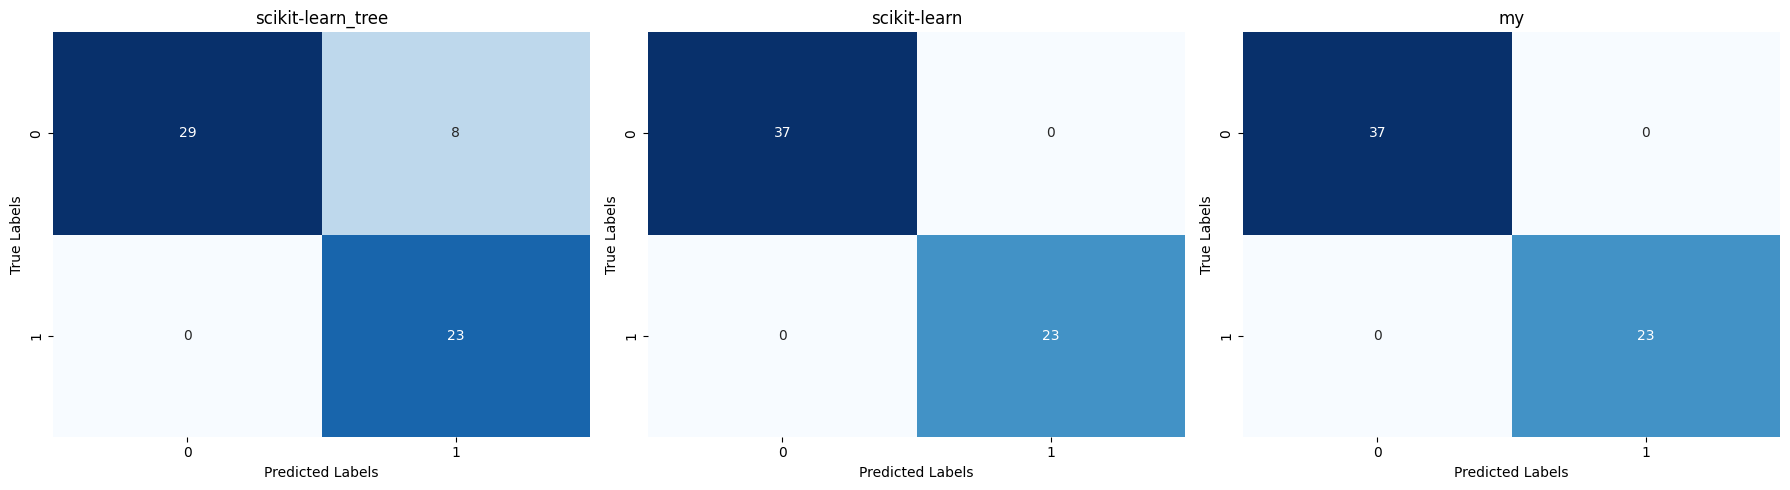

In [12]:
plot_confusion_matrices(predictions, y_test, n_cols=3)

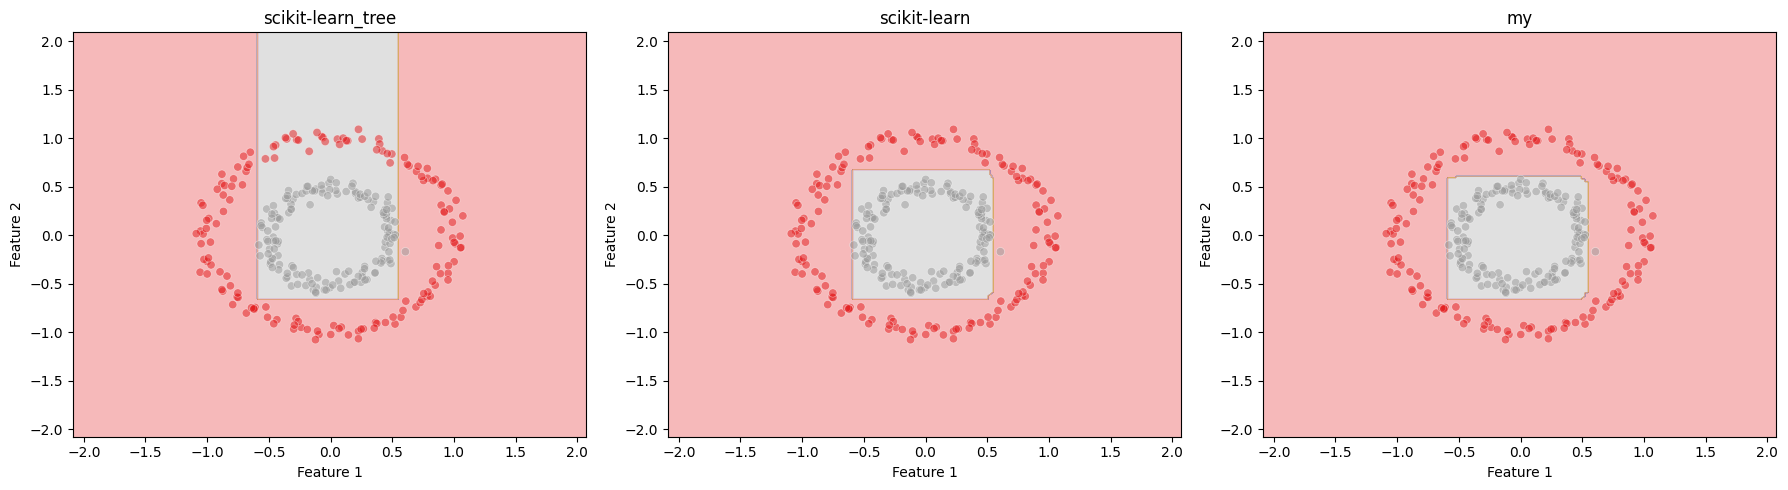

In [13]:
plot_decision_tree_boundaries(models, X, y, n_cols=3)